In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from models import base_networks as bn
from models.base_networks import MLP_iResNet, LinearNet, MLP




import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'

rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
datpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3'






In [2]:
os.listdir(datpath)

['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_Linear_shared_trans.pt']

In [3]:
embed_fxn_mode = 'MLP'
modelmode = 'so3'
num_blocks = 2
tensor_dim = 10 

modelpath = f"""{modelmode}dat_sphere_{embed_fxn_mode}_model.pt"""
datapath = f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt"""

dataconfig = {'args': {'T': 8, 'data_filename': f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt""", 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

modelconfig = {'args': {'ch_x': 1, 'dim_a': 6, 'dim_m': 10, 'k': 2.0, 'predictive': True},
 'fn': './models/seqae.py',
 'name': f"""SeqAELSTSQ_{modelmode}Net"""}

data = yu.load_component(dataconfig)
datafile = torch.load(os.path.join(datpath, datapath))



if embed_fxn_mode == 'iResNet':
    embed_fxn = MLP_iResNet(in_dim=3*num_blocks*tensor_dim)
    inv_fxn = MLP_iResNet(in_dim=3*num_blocks*tensor_dim)

elif embed_fxn_mode == 'Linear':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = LinearNet(in_dim=indim, out_dim=outdim)
    inv_fxn = LinearNet(in_dim=indim, out_dim=outdim)
    mylr = 0.01

elif embed_fxn_mode == 'MLP':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = MLP(in_dim=indim, out_dim=outdim)
    inv_fxn = MLP(in_dim=indim, out_dim=outdim)
    mylr = 0.001
    
else:
    raise NotImplementedError

model_dict = torch.load(os.path.join(datpath, modelpath))
embed_fxn.load_state_dict(model_dict, strict=False)


latent = datafile['latent']
print(latent.shape)
latent_inform = rearrange(latent, 'n t a m -> (n t) (a m)')
print(latent_inform.shape)

dathat_inform = embed_fxn(latent_inform)
datat = datafile['data']

print(datat.shape)
dat_inform = rearrange(datat, 'n t am -> (n t) am')
print(dat_inform.shape)
dat_inform - embed_fxn(latent_inform)

print(datat.shape)


train_loader = DataLoader(latent_inform, 
                          batch_size=100,
                          shuffle=True,
                          num_workers=2)

torch.Size([10000, 15, 6, 10])
torch.Size([150000, 60])
torch.Size([10000, 15, 60])
torch.Size([150000, 60])
torch.Size([10000, 15, 60])


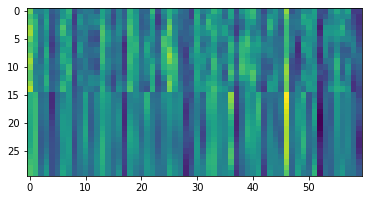

In [4]:
plt.imshow(dathat_inform[:30, :60].detach())

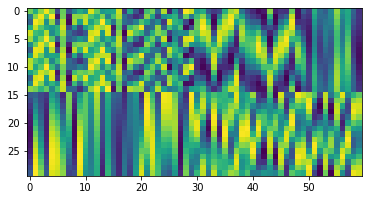

In [5]:
plt.imshow(latent_inform[:30, :60])

MLP(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=60, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=60, bias=True)
  )
)

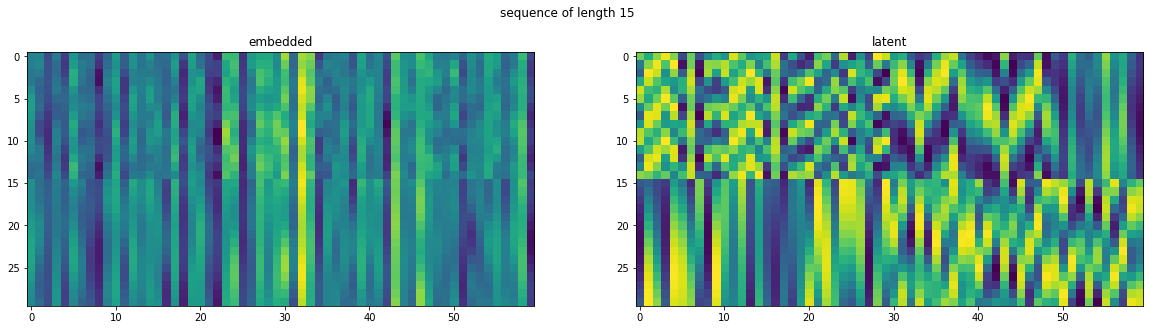

In [6]:
reload(bn)
try_fxn =  bn.MLP(in_dim=indim, out_dim=outdim)
#try_fxn =  bn.MLP_iResNet(in_dim=3*num_blocks*tensor_dim)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.imshow(try_fxn(latent_inform).detach()[:30, :60])
plt.title('embedded')
plt.subplot(122)
plt.imshow(latent_inform.detach()[:30, :60])
plt.title('latent')
plt.suptitle("sequence of length 15")
try_fxn

In [7]:
train_loader = DataLoader(latent_inform, 
                          batch_size=1000,
                          shuffle=True,
                          num_workers=2)

In [14]:
device = 0
optimizer = torch.optim.Adam(inv_fxn.parameters(), lr=mylr)

num_epoch = 150
iternow = 0 
inv_fxn.to(device)
embed_fxn.to(device)



for epoch in range(num_epoch):
    
    loss_total = 0
    for batch_idx, lat_batch in enumerate(train_loader):
        lat_batch = lat_batch.to(device)
        loss = torch.sum( (lat_batch - inv_fxn(embed_fxn(lat_batch)))**2).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total = loss_total + loss.item()
    loss_mean = loss_total / len(train_loader.dataset)
    if epoch % 5 == 0:
        print(f"""Epoch {epoch} \t Loss \t {loss_mean} """ )
        print(lat_batch.shape)

Epoch 0 	 Loss 	 6.221787174479167 
torch.Size([1000, 60])
Epoch 5 	 Loss 	 5.707696676432292 
torch.Size([1000, 60])
Epoch 10 	 Loss 	 5.6968077278645834 
torch.Size([1000, 60])
Epoch 15 	 Loss 	 5.687477470703125 
torch.Size([1000, 60])
Epoch 20 	 Loss 	 5.657143668619792 
torch.Size([1000, 60])
Epoch 25 	 Loss 	 5.628139326171875 
torch.Size([1000, 60])
Epoch 30 	 Loss 	 5.616337841796875 
torch.Size([1000, 60])
Epoch 35 	 Loss 	 5.585427259114583 
torch.Size([1000, 60])
Epoch 40 	 Loss 	 5.583247591145834 
torch.Size([1000, 60])
Epoch 45 	 Loss 	 5.566373697916666 
torch.Size([1000, 60])
Epoch 50 	 Loss 	 5.54786314453125 
torch.Size([1000, 60])
Epoch 55 	 Loss 	 5.544644850260417 
torch.Size([1000, 60])
Epoch 60 	 Loss 	 5.550664313151041 
torch.Size([1000, 60])
Epoch 65 	 Loss 	 5.530690895182292 
torch.Size([1000, 60])
Epoch 70 	 Loss 	 5.523668050130208 
torch.Size([1000, 60])
Epoch 75 	 Loss 	 5.505440703125 
torch.Size([1000, 60])
Epoch 80 	 Loss 	 5.50389966796875 
torch.Siz

In [11]:
latent_inform = latent_inform.to('cpu')
dat_inform = dat_inform.to('cpu')
latent = latent.to('cpu')
inv_fxn.to('cpu')
torch.sum(torch.abs(latent_inform.reshape([10000, 15, 6, 10])  - latent))
latent_hat = inv_fxn(dat_inform).reshape([10000, 15, 6, 10]).detach().numpy()



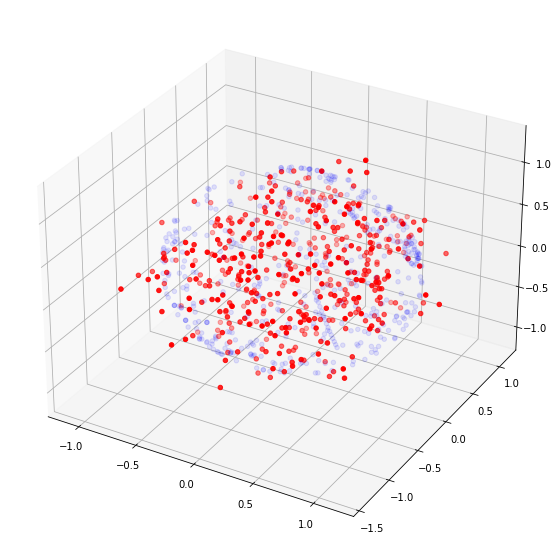

In [13]:




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys



myslice = 1
pos=1

for k in range(30):
    dat = latent[k]
    dathat = latent_hat[k]
    color = np.random.uniform(0, 1, size=1)
    ax.scatter(dat[:,pos*3+0,myslice], dat[:,pos*3+1,myslice], dat[:,pos*3+2,myslice], color='blue', alpha=0.1)
    ax.scatter(dathat[:,pos*3+0,myslice], dathat[:,pos*3+1,myslice], dathat[:,pos*3+2,myslice], color='red')



    #for t in range(15):


